# Setting up simulations of your own

The ultimate aim of TCV-X21 is that the validation case can be replicated by
other simulations, and that the experimental dataset serves as a benchmark
for comparing and validating turbulence simulations.

For that, we need *you* to be able to set up simulations with a turbulence
code of your own.

For this, you'll need

1. A turbulence code of your own
2. The reference equilibrium
3. Sources
4. Physical parameters

You can find data files for the experimental reference scenario in
`data/experimental_reference/reference_scenario`.

In [1]:
# Set up the analysis environment

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset

import tcvx21
from tcvx21 import Quantity
# Apply the custom style sheet, which makes the plots look the same
plt.style.use(tcvx21.style_sheet_inline)

## The reference equilibrium

We develop a simple lower-single-null diverted magnetic geometry as the "reference
scenario". We performed several discharges in the reference scenario to gather
the experimental reference dataset. Next, we performed simulations in both
field directions of a "reference scenario": TCV shot number 65402 at
$t=1$s. The reference scenario represents a typical discharge from the
experimental discharges, and it is the case modelled by the codes. Note that
the simulations *do not use baffles* (unlike the shot number given here).

The reference equilibrium is available in several file-formats: including
`eqdsk`, `.mat` (MATLAB data file), and a labelled PARALLAX-type NetCDF.
We demonstrate here the use of the labelled NetCDF. Note that in the figure
shown here is in *normalised units*. All the spatial distances are
divided by $R_0 = 0.90586$m.

Text(0, 0.5, '$\\Psi$ [Weber]')

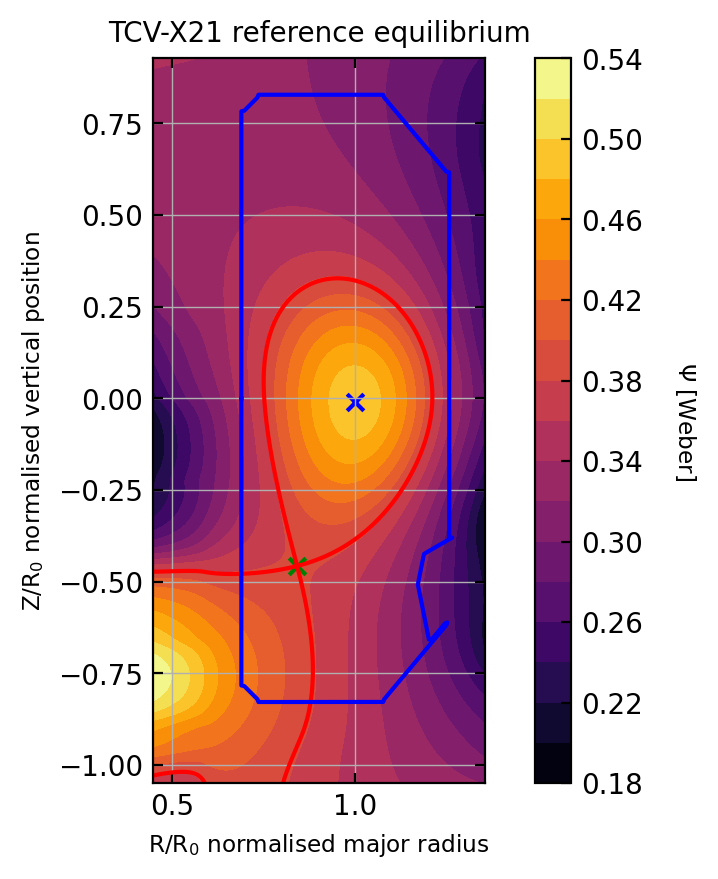

In [2]:
# Load the equilibrium
equi = Dataset(tcvx21.experimental_reference_dir/'reference_scenario/reference_equilibrium.nc')

fig, ax = plt.subplots()

# Plot the flux surfaces
plt.contourf(equi['Magnetic_geometry/R'][:],
             equi['Magnetic_geometry/Z'][:],
             equi['Magnetic_geometry/psi'][:],
             levels=20)

cbar = plt.colorbar()

# Plot the separatrix
plt.contour(equi['Magnetic_geometry/R'][:],
            equi['Magnetic_geometry/Z'][:],
            equi['Magnetic_geometry/psi'][:],
            levels=[equi['Psi_limits'].psi_seperatrix], colors='red')

# Plot the divertor
plt.plot(equi['divertor_polygon/R_points'],
         equi['divertor_polygon/Z_points'], color='blue')

# Highlight the magnetic axis and X-point
R0 = equi['Magnetic_geometry'].magnetic_axis_R #in metres
plt.scatter(equi['Magnetic_geometry'].magnetic_axis_R/R0,
            equi['Magnetic_geometry'].magnetic_axis_Z/R0,
            marker='x', color='blue')
plt.scatter(equi['Magnetic_geometry'].x_point_R/R0,
            equi['Magnetic_geometry'].x_point_Z/R0,
            marker='x', color='green')

# Make the plot look nice and add labels
ax.set_aspect('equal')
ax.set_title("TCV-X21 reference equilibrium")
ax.set_xlabel('$R/R_0$ normalised major radius')
ax.set_ylabel('$Z/R_0$ normalised vertical position')

cbar.ax.set_ylabel('$\Psi$ [Weber]', rotation=270, labelpad=20)

The equilibrium file should give you enough information to exactly replicate
the magnetic field structure of the TCV-X21 reference equilibrium. To
construct the poloidal magnetic field from the equilibrium file, you can
check the methods of `tcvx21.grillix_analysis.equi_m.Equi`.

For the toroidal magnetic field strength, we assume
$B_\phi = B_{\phi, axis}\frac{R_0}{R}$

Text(0, 0.5, '$B_{pol}$ [Tesla]')

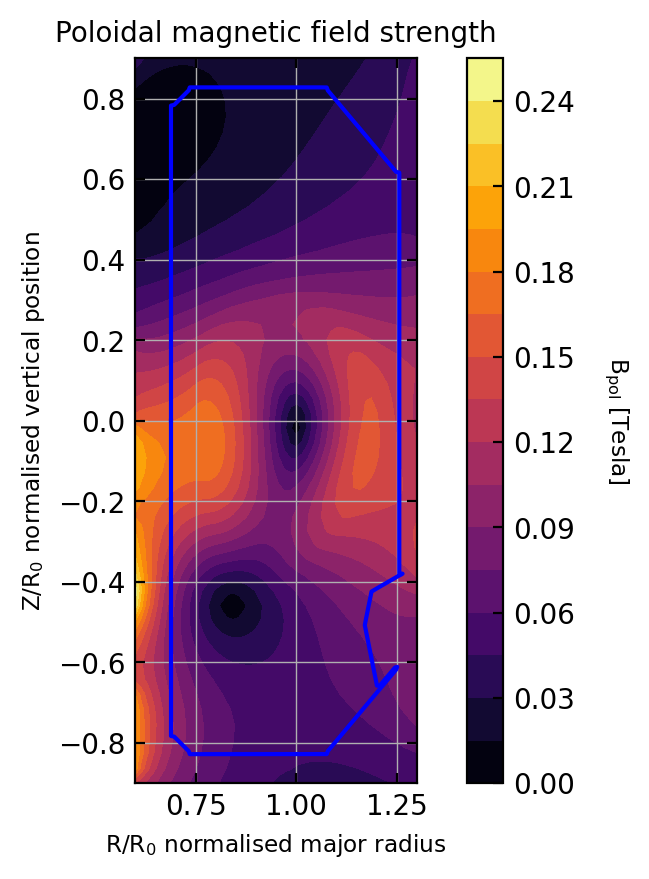

In [3]:
from tcvx21.grillix_post.components.equi_m import Equi

grillix_equi = Equi(tcvx21.experimental_reference_dir/'reference_scenario/reference_equilibrium.nc')

fig, ax = plt.subplots()

r_test, z_test = np.linspace(0.6, 1.3), np.linspace(-0.9, 0.9)
plt.contourf(r_test, z_test,
             np.sqrt(  grillix_equi.magnetic_field_r(r_test, z_test, grid=True)**2
                     + grillix_equi.magnetic_field_z(r_test, z_test, grid=True)**2),
             levels=20)
cbar = plt.colorbar()

plt.plot(equi['divertor_polygon/R_points'],
         equi['divertor_polygon/Z_points'], color='blue')

ax.set_aspect('equal')
ax.set_title("Poloidal magnetic field strength")
ax.set_xlabel('$R/R_0$ normalised major radius')
ax.set_ylabel('$Z/R_0$ normalised vertical position')

cbar.ax.set_ylabel('$B_{pol}$ [Tesla]', rotation=270, labelpad=20)

## Sources

The source functions used by GRILLIX are given in `tcvx21/grillix_post/components/sources_m.py`

### Density source or neutrals

The scenario is fuelled from above, away from the divertor, to try to
reduce the amount of neutrals ionised in the divertor.
We expect that the neutrals are mostly ionised just inside the confined region (this is
called "low-recycling": this doesn't mean that there is no neutral recycling,
just that the recycled neutrals should be primarily ionised in the confined
region).

There are two ways that this could be treated.

1. Approximate the neutral ionisation as a confined-region source
2. Self-consistently treat the neutral dynamics to determine the source rate

For the initial evaluation we select option 1 for simplicity.
Nevertheless, we note that using this approximation
is likely our greatest source of disagreement, and are interested in
comparing to simulations with neutrals.

The total particle source rate isn't known exactly. We expect that
most of the density source results from recycled neutrals rather than
from neutrals injected from the gas fuelling port (and we don't have a
good estimate of the gas fuelling rate anyway). As such, the
density source rate (or neutral pressure) must be manually adjusted (see
tuning the sources).

The density source used by GRILLIX is

$S_n = \hat{S}_n \exp\left[ -(\rho^2 - \rho_c^2)/\rho_w\right]$

where $\hat{S}_n$ is a source rate, $\rho_c = 0.915141$ is the source centre and
$\rho_w = 0.083797$ is the source width.

### Temperature or power source

The shots are Ohmically heated (resistive heating due to transformer-driven
current). We approximate this as a power source near the magnetic axis.

The electron temperature source is modified to give a constant power injection. The
power integral is

$ P = \frac{3}{2}\iiint n S_{T_e} + (T_e + T_i) S_n \textrm{d}^3V$

which has contributions both from the electron temperature source and from the density
source (since adding plasma at a certain temperature requires energy). In GRILLIX,
we rearrange this to find an expression for $S_{T_e}$ which gives a constant power
rate (where $\hat{x} = x / x_0$ is a normalised form of $x$, with normalisation factor $x_0$)

$S_{T_e} = T_{e0} / \tau_0 \left(\frac{1}{\hat{n}}\hat{S}_{T_{e,core}} - \frac{\hat{T}_e + \hat{T}_i}{\hat{n}} \hat{S}_n \right)$

This allows us to write

$P = \frac{3}{2}\iiint n_0 \hat{n} T_{e0} / \tau_0 \left(\frac{1}{\hat{n}}\hat{S}_{T_{e,core}} - \frac{\hat{T}_e + \hat{T}_i}{\hat{n}} \hat{S}_n \right) + T_{e0}(\hat{T}_e + \hat{T}_i) n_0 / \tau_0 \hat{S}_n \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_{e0}}{\tau_0} \iiint \hat{S}_{T_{e,core}} - (\hat{T}_e + \hat{T}_i) \hat{S}_n + (\hat{T}_e + \hat{T}_i) \hat{S}_n \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_{e0}}{\tau_0} \hat{S}_{T_{e,core}} \iiint f_{S,Te}(R,Z) \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_{e0}}{\tau_0} \hat{S}_{T_{e,core}} \mathcal{V}_w$


Substituting this into the power integral gives
$ P = \frac{3}{2} \int S_{T_{e,core}} d^3V$

Then we set
$S_{T_{e,core}} = 1 - \mathcal{S}_3(\rho, \rho_c, \rho_w)$
for $\mathcal{S}_3$ a third-order [smoothstep](https://en.wikipedia.org/wiki/Smoothstep)
function, centred at $\rho_c = 0.3$ and of width $\rho_w =0.3$.

The term $\mathcal{V}_w$ is the effective weighted volume of the source, which we can
use to work out the required source rate.

Note that we are only taking energy out of the electron population to compensate for the density source.

In [4]:
from tcvx21.grillix_post import components
from tcvx21.grillix_post.components.sources_m import density_source_function, smoothstep

file_path = tcvx21.test_dir / 'sample_data'

grid = components.Grid(file_path / 'vgrid.nc')
norm = components.Normalisation.initialise_from_normalisation_file(file_path/'physical_parameters.nml')
snaps = components.read_snaps_from_file(file_path, norm, time_slice=slice(None), all_planes=True)
equi = components.Equi(file_path/'TCV_ortho.nc',
                file_path/'pen_metainfo.nc',
                flip_z=True)

parameter_filepath = tcvx21.grillix_post.filepath_resolver(file_path, 'params.in')
params = components.convert_params_filepaths(parameter_filepath, components.read_fortran_namelist(parameter_filepath))

rho = equi.normalised_flux_surface_label(grid.r_s, grid.z_s)

density_source_rate = params['params_srcsnk']['csrcn']
etemp_source_rate = params['params_srcsnk']['csrcte']

density_source = density_source_function(rho, grid.districts, norm, source_strength=1.0)
core_source = xr.DataArray(1 - smoothstep(rho, step_centre=0.3, step_width=0.3)).where(grid.districts == "CLOSED", 0.0)

### Visualising the sources



Text(0.5, 1.0, 'Source positions')

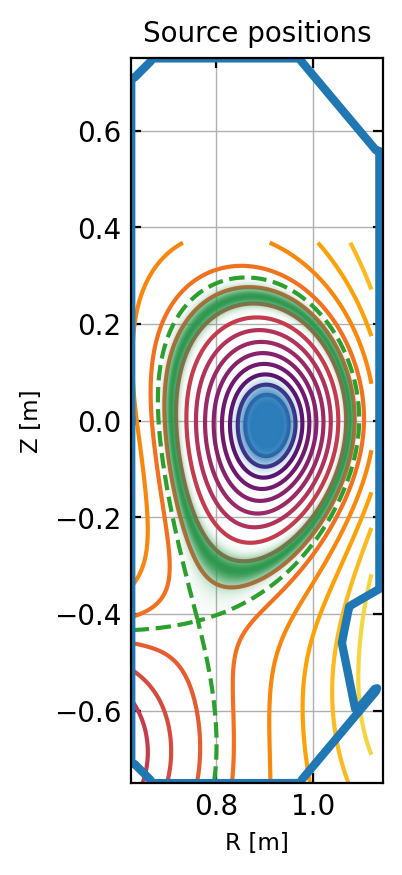

In [5]:
from tcvx21.plotting.plot_array_as_transparency_m import plot_array_as_transparency

fig, ax = plt.subplots()

flip_z = -1.0 if equi.flipped_z else 1.0

# First, let's plot the magnetic data flux surfaces
ax.contour(grid.r_s * R0, grid.z_s * R0 * flip_z, rho, levels=20)

# Plot the sources, and bring them to in front of the flux-surfaces
im = plot_array_as_transparency(ax, grid.r_s * R0, grid.z_s * R0 * flip_z, alphas = np.flipud(density_source), cmap=plt.cm.Greens, intensity=0.7)
im.set_zorder(np.inf)
im = plot_array_as_transparency(ax, grid.r_s * R0, grid.z_s * R0 * flip_z, alphas = np.flipud(core_source), cmap=plt.cm.Blues, intensity=0.7)
im.set_zorder(np.inf)

divertor_ = tcvx21.read_from_json(tcvx21.experimental_reference_dir/'reference_scenario/divertor_polygon.json')
separatrix = tcvx21.analysis.find_contours(grid.r_s * R0, grid.z_s * R0, rho, level=1.0)[0]

# Mark the separatrix
ax.plot(separatrix[:, 0], separatrix[:, 1] * flip_z, 'C2', label='Separatrix', linestyle='--')
# Mark the divertor
ax.plot(divertor_['r_points'], divertor_['z_points'], color='C0', label='Vessel', linewidth=2.0*plt.rcParams['lines.linewidth'])
# Set the plot limits in terms of the divertor
ax.set_xlim(divertor_['r_points'].min(), divertor_['r_points'].max())
ax.set_ylim(divertor_['z_points'].min(), divertor_['z_points'].max())
ax.set_aspect('equal')

plt.xlabel('R [m]')
plt.ylabel('Z [m]')
plt.title('Source positions')

### Tuning the sources

Depending on the type of source that you use, you have a number of free parameters. Either you
will need to adjust

* Density source rate and temperature source rate (electrons and possibly ions)
* Density source rate and power source rate

For this, you can tune the sources to match the following experimental constraints

* Separatrix density of $\approx 6\times 10^{18} m^{-3}$
* Separatrix electron temperature of $\approx 40 eV$
* Total injected power of $150 kW$
* Power crossing the separatrix of $\approx 120 kW$ (estimated from bolometry)
* Total particle recycling of (very roughly) $\approx 3\times 10^{31} s^{-1}$ (estimated from total out-flux to
  wall Langmuir probes, assuming perfect recycling).

In GRILLIX, we set the total injected power to $150 kW$ and then tune the density source
to match the separatrix density. We use the same sources in both field directions.

We can work out exactly what the required core $T_e$ source rate is, by computing the
$\mathcal{V}_w$ "effective weighted volume" of the core source, which allows us to then
find the source rate as

$\hat{S}_{T_e}= P / \left(\frac{3}{2}\frac{n_0 T_0}{\tau_0} \mathcal{V}_w\right)$

In [6]:
from tcvx21.grillix_post.observables.integrations_m import axisymmetric_cylindrical_integration
from tcvx21.grillix_post.components.sources_m import core_temperature_source_function
from tcvx21 import Dimensionless

core_source_volume = axisymmetric_cylindrical_integration(
    grid, norm, core_temperature_source_function(
        rho, grid.districts, norm, source_strength=1.0, source_centre=0.3, source_width=0.3).assign_attrs(norm=Dimensionless))

desired_power = Quantity(150, 'kilowatt')
print(f"Effective weighted core source volume: {core_source_volume}")
print(f"Required source rate: {(desired_power / core_source_volume).to('MW m^-3')}")
print(f"Dimensionless source rate: {(desired_power / (1.5 * core_source_volume * norm.Te0 * norm.n0 / norm.tau_0)).to('')}")

Effective weighted core source volume: 0.0821036922384391 meter ** 3
Required source rate: 1.8269580320989924 megawatt / meter ** 3
Dimensionless source rate: 0.3749632734361017 dimensionless


## Physical parameters

In turbulence simulations, usually you'll convert to dimensionless quantities, such that all
modelled equations are in terms of unitless quantities. The normalisation factors can be
computed from physical parameters of the system.

The codes do not fix the profiles, so the exact choice of the normalisation factors isn't so
important. The file `data/experimental_reference/reference_scenario/physical_parameters.nml` contains
the following physical parameters (in Fortran namelist format)

```
&physical_parameters
    case_name = TCV_65402
    ! Magnetic field normalisation, usually taken on axis, in Tesla
    B0 = 0.929
    ! Electron temperature normalisation, in electron-volts
    Te0 = 41.3
    ! Ion temperature normalisation, in electron-volts
    Ti0 = 41.3
    ! Density normalisation, in particles-per-cubic-metres
    n0 = 1E19
    ! Major radius, in metres
    R0 = 0.906
    ! Ion mass, in amu
    Mi = 2
    ! Ion charge, in e
    Z = 1
    ! Ion effective charge, in e
    Z_eff = 1.5
/
```

In GRILLIX, we use these physical parameters to calculate normalisation factors (using the excellent `pint`
unit handling library). You can see the calculation and definition of the terms in
`tcvx21/grillix_post/components/normalisation_m.py`.

You'll need to do this for your own code, but this might provide a helpful starting point.

Of the normalisation parameters, the reference ion drift scale is important, since
we set our grid resolution in terms of it.

In [7]:
print(norm)
print(f"Reference ion drift scale is {norm.rho_s0.to('mm'):3.2}")

	Value                         	Magnitude 	Units               
	atomic_mass_units             	1.0000e+00	unified_atomic_mass_unit      
	B0                            	9.2900e-01	tesla                         
	beta_0                        	9.6347e-05	dimensionless                 
	c_s0                          	4.4475e+04	meter / second                
	chipar_e                      	2.7193e+02	dimensionless                 
	chipar_i                      	1.1748e+01	dimensionless                 
	delta                         	9.0638e+02	dimensionless                 
	electron_mass                 	1.0000e+00	electron_mass                 
	elementary_charge             	1.0000e+00	elementary_charge             
	etapar                        	5.9265e-03	dimensionless                 
	ion_viscosity                 	2.8919e+00	dimensionless                 
	lnLambda0                     	1.2754e+01	dimensionless                 
	Mi                            	2.0000e+00	proto

### Core profiles

You might also need core profiles, such as for setting up initial condition.

Since these were not included in the analysis, these haven't been checked as
thoroughly as the edge profiles, but they still might be helpful.

Note that ion temperature in forward field is not available.

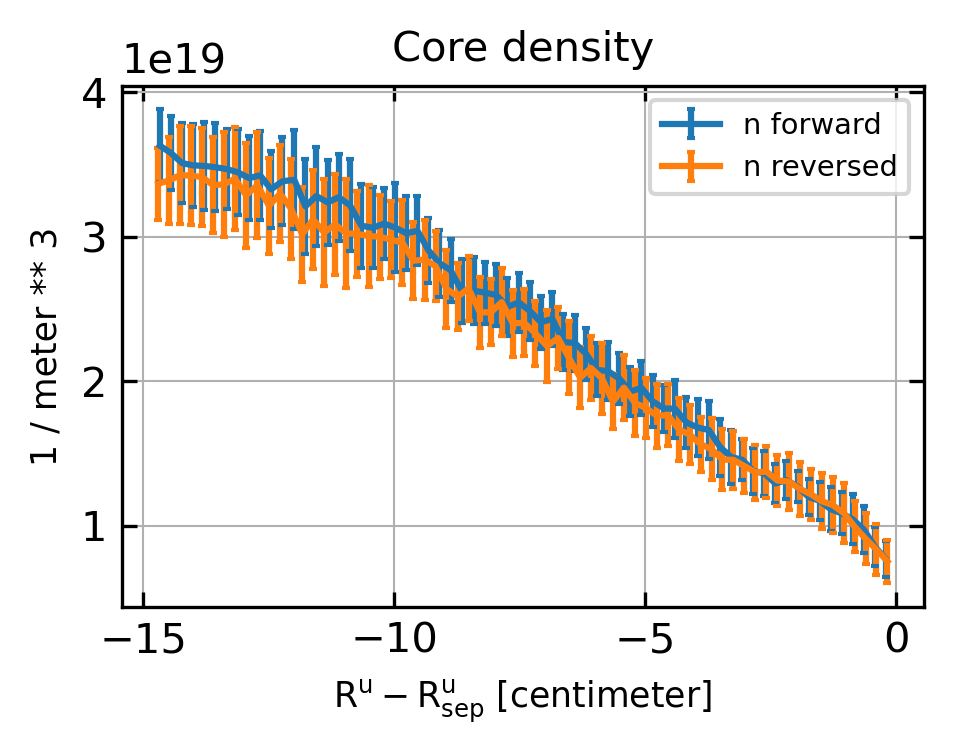

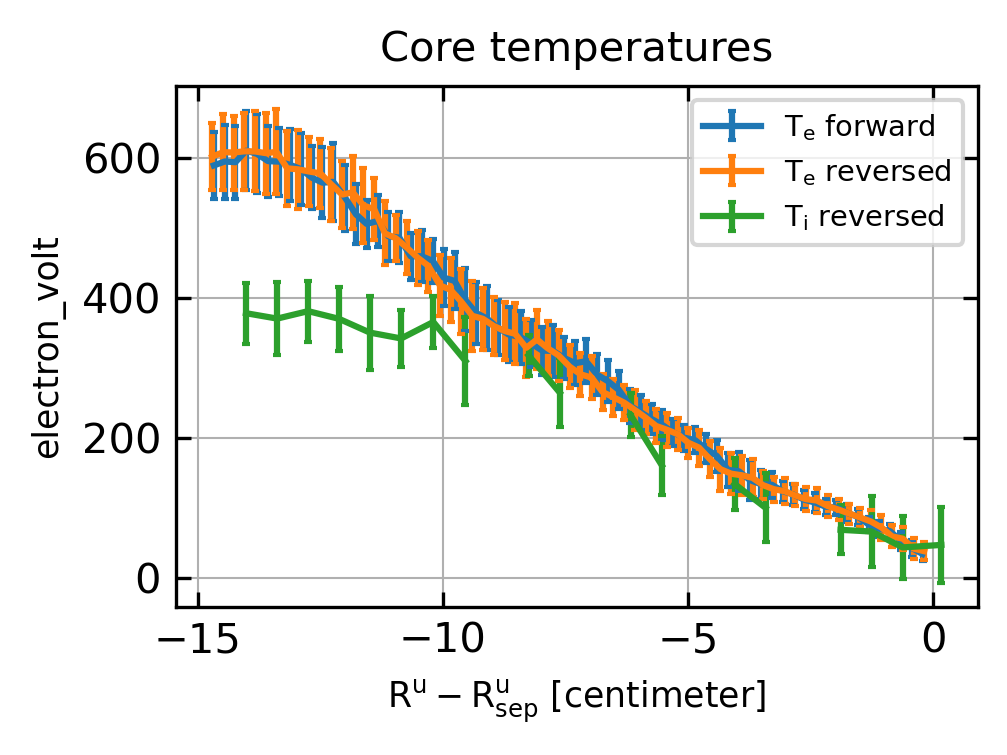

In [8]:
plt.style.use(tcvx21.style_sheet)
core_profiles = tcvx21.read_struct_from_file(tcvx21.experimental_reference_dir/'reference_scenario/dataset_TCV_CORE.mat')

def plot_from_matlab(data, label):
    r, r_units, val, err, units = [data[key] for key in ['r', 'r_units', 'val', 'err', 'val_units']]

    r = Quantity(r, r_units.lstrip('[').rstrip(']'))
    val = Quantity(val, units.lstrip('[').rstrip(']'))
    err = Quantity(err, units.lstrip('[').rstrip(']'))

    plt.errorbar(r, val, err, label=label)
    plt.xlabel(f'$R^u - R^u_{{sep}}$ [{r.units}]')
    plt.ylabel(f'{val.units}')

fig, ax = plt.subplots()
plot_from_matlab(core_profiles['Forw']['ne'], 'n forward')
plot_from_matlab(core_profiles['Rev']['ne'], 'n reversed')
plt.title('Core density')
plt.legend()

fig, ax = plt.subplots()
plot_from_matlab(core_profiles['Forw']['Te'], '$T_e$ forward')
plot_from_matlab(core_profiles['Rev']['Te'], '$T_e$ reversed')
plot_from_matlab(core_profiles['Rev']['Ti'], '$T_i$ reversed')
plt.title('Core temperatures')
plt.legend()

## Conclusion

Hopefully, this is enough for you to start a simulation of
your own. If not, let us know via Gitlab issues, and we'll
extend the documentation and data accordingly.

To post-process and compare to TCV-x21, you'll need to extract the data at a
series of measurement positions. We do this in `simulation_postprocessing.ipynb`.

